# Tutorial 4: mouse embryonic (E15.5) brain by MISAR-seq data(Multi-omics Dataset)

the MISAR-seq datasets are available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE213264

## Loading and Preparing Data

In [1]:
import pandas as pd  
import numpy as np  
import scanpy as sc  
import anndata as ad  
import h5py  
import matplotlib.pyplot as plt  
from sklearn.metrics import adjusted_rand_score  
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi  
from SEPAR_model import SEPAR  

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load ATAC data  
with h5py.File('/Users/zhang/Documents/SEPAR_upload/dataset/MISAR_seq/MISAR_seq_mouse_E15_brain_ATAC_data.h5', 'r') as f:  
    x_atac = np.array(f['X'], dtype='float64')  
    loc = np.array(f['pos'], dtype='float64')  
    peak_names = np.array(f['peak'], dtype=str)  
    Y_atac = np.array(f['Y'])  
    cell_atac = np.array(f['cell'], dtype=str)  

# Load RNA data  
with h5py.File('/Users/zhang/Documents/SEPAR_upload/dataset/MISAR_seq/MISAR_seq_mouse_E15_brain_mRNA_data.h5', 'r') as f:  
    x_rna = np.array(f['X'], dtype='float64')  
    gene_names = np.array(f['gene'], dtype=str)  
    cell_rna = np.array(f['cell'], dtype=str)  

# Create AnnData objects  
adata_atac = ad.AnnData(  
    X=x_atac,  
    obs=pd.DataFrame({'cell_ids': cell_atac}),  
    var=pd.DataFrame(index=peak_names)  
)  

adata_rna = ad.AnnData(  
    X=x_rna,  
    obs=pd.DataFrame({'cell_ids': cell_rna}),  
    var=pd.DataFrame(index=gene_names)  
)  

# Normalize each modality  
sc.pp.normalize_total(adata_atac, target_sum=1e4)  
sc.pp.log1p(adata_atac)  
sc.pp.normalize_total(adata_rna, target_sum=1e4)  
sc.pp.log1p(adata_rna)  

# Combine modalities  
x_combined = np.concatenate((adata_atac.X, adata_rna.X), axis=1)  
var_combined = pd.concat([  
    adata_atac.var.assign(batch='ATAC'),  
    adata_rna.var.assign(batch='RNA')  
])  

# Create combined AnnData  
adata_combined = ad.AnnData(  
    X=x_combined,   
    obs=adata_atac.obs,   
    var=var_combined  
)  
adata_combined.obsm['spatial'] = loc

## Data Preprocessing and Analysis

After filtering:  (1949, 49431)


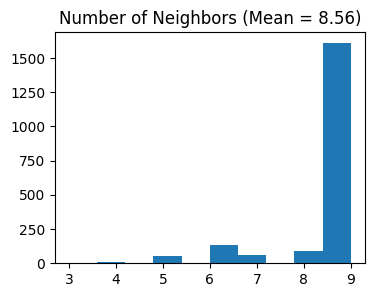

Counting moran's i ...

Finish selecting
Selected features per modality: batch
ATAC    4460
RNA      540
Name: count, dtype: int64


In [3]:
# Initialize SEPAR  
n_cluster = len(np.unique(Y_atac))  
separ = SEPAR(adata_combined, n_cluster=n_cluster)  

# Preprocess without additional normalization  
separ.preprocess(min_cells=50, normalize=False)  
separ.compute_graph(radius_rate=1.3)  

# Feature selection  
separ.select_morani(nslt=5000)  

# Check modality distribution  
batch_counts = separ.adata.var['batch'].value_counts()  
print("Selected features per modality:", batch_counts)

## Running SEPAR Algorithm

In [4]:
# Compute weights and run SEPAR  
separ.compute_weight(n_cluster=n_cluster)  
separ.separ_algorithm(  
    r=30,              # Number of patterns  
    alpha=0.5,         # Graph regularization  
    beta=0.01,         # Sparsity penalty (previously l1)  
    gamma=0.5,         # Pattern orthogonality (previously lam)  
    mean=False  
)

Processing iterations: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


## Identifying Pattern-Specific Genes/Peaks

In [5]:
pattern_specific_features = separ.identify_pattern_specific_genes(  
    n_patterns=30,   
    threshold=0.3  
)  

for i in range(30):  
    batch_counts = separ.adata.var['batch'][separ.pattern_specific_mask[i]].value_counts()  

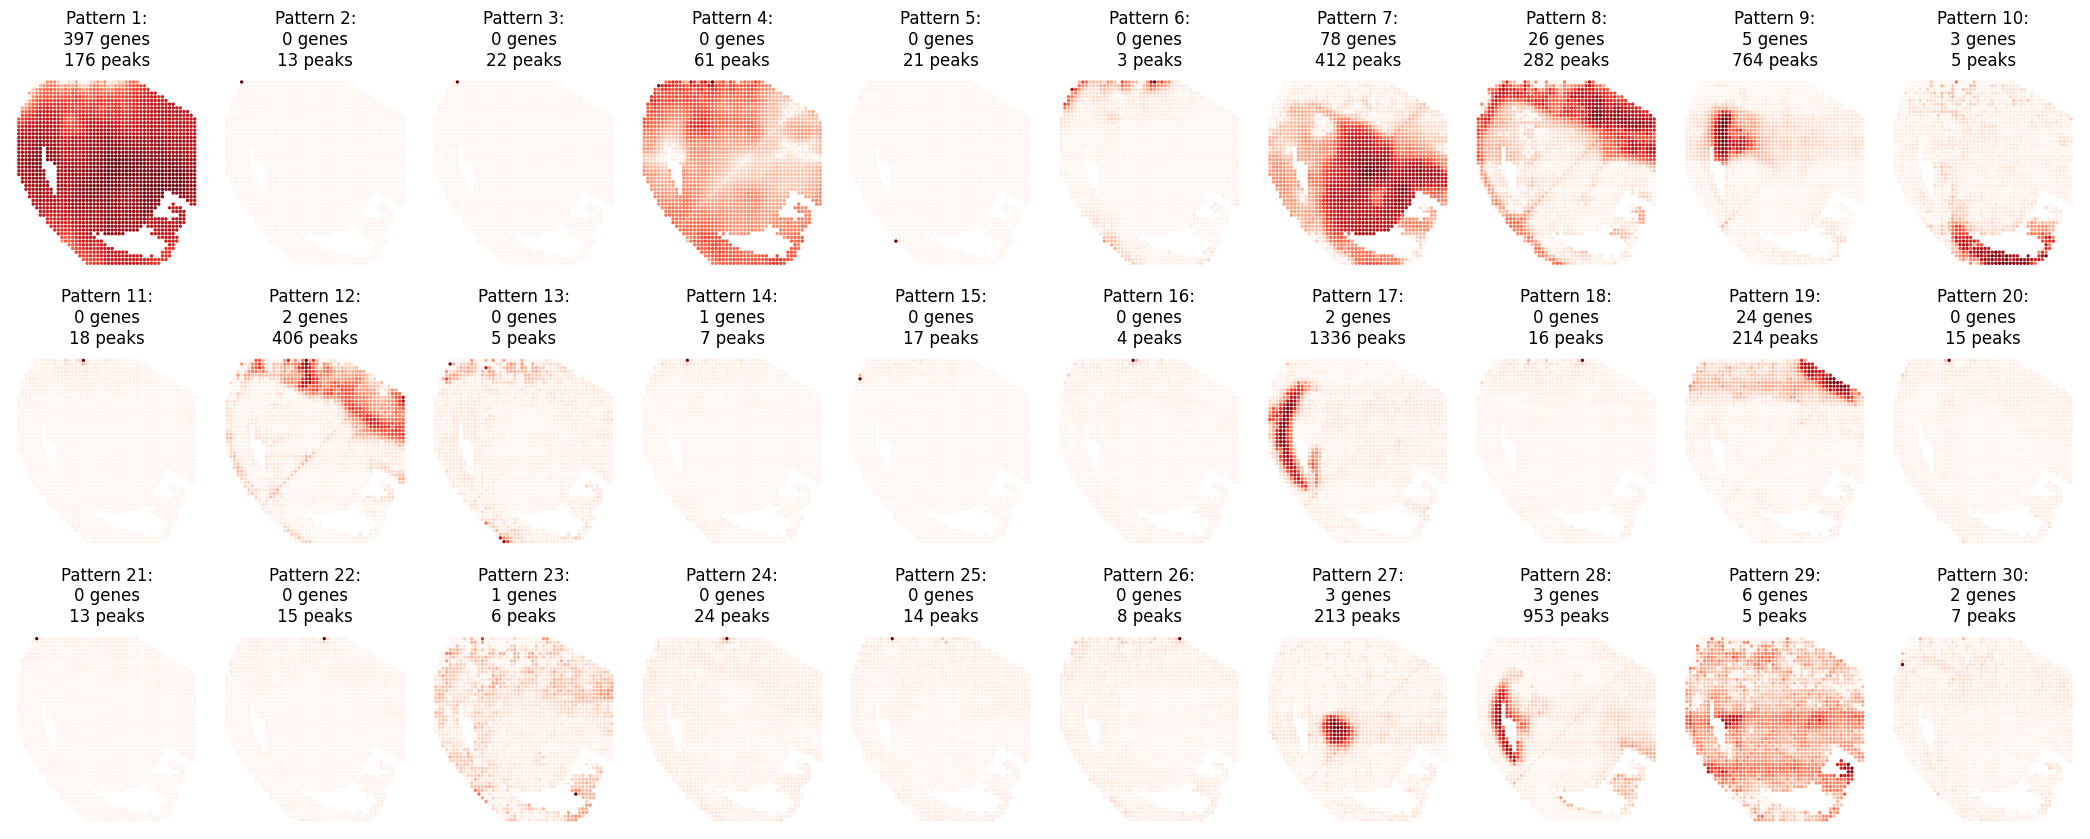

In [6]:
# Visualize all spatial patterns  
sim_slt = separ.sim_res(separ.Wpn, separ.Hpn, separ.Xt.T)  
sim_argsort = np.argsort(-sim_slt)  

num_patterns = 30  
plt.figure(dpi=100, figsize=(21, 8.5))  

for i in range(num_patterns):  
    ii = sim_argsort[i]  
    
    # Get pattern-specific features  
    pattern_features = separ.pattern_specific_mask[ii]  
    
    # Count genes and peaks  
    genes_count = sum(separ.adata.var.loc[pattern_features, 'batch'] == 'RNA')  
    peaks_count = sum(separ.adata.var.loc[pattern_features, 'batch'] == 'ATAC')  
    
    # Create subplot  
    plt.subplot(3, num_patterns//3, i + 1)  
    plt.scatter(separ.loc[:, 0], -separ.loc[:, 1],   
                c=separ.Wpn[:, ii].reshape(-1, 1),   
                s=2, cmap='Reds')  
    plt.axis('off')  
    
    # Add title with both counts  
    plt.title(f'Pattern {i + 1}:\n{genes_count} genes\n{peaks_count} peaks',   
              fontsize=12)  

plt.tight_layout()  
plt.show()

In [7]:
# Create and display sorted pattern-specific features table  
print("\nTop Pattern-Specific Features (Sorted by Pattern Significance):")  
print("-" * 120)  
print(f"{'Pattern':11} | {'Significance':11} | {'#Genes':8} | {'#Peaks':8} | {'Top Genes':30} | {'Top Peaks'}")  
print("-" * 120)  

for rank, pattern_idx in enumerate(sim_argsort[:num_patterns]):  
    # Get features for this pattern  
    pattern_features = pattern_specific_features[pattern_idx]  
    
    # Separate genes and peaks  
    genes = pattern_features[separ.adata.var.loc[pattern_features, 'batch'] == 'RNA']  
    peaks = pattern_features[separ.adata.var.loc[pattern_features, 'batch'] == 'ATAC']  
    
    # Format gene string  
    if len(genes) == 0:  
        gene_str = "None"  
    else:  
        gene_str = ", ".join(genes[:5])  
        if len(genes) > 5:  
            gene_str += "..."  
            
    # Format peak string  
    if len(peaks) == 0:  
        peak_str = "None"  
    else:  
        peak_str = ", ".join(peaks[:2])  
        if len(peaks) > 2:  
            peak_str += "..."  
    
    print(f"Pattern {rank+1:<3} | {sim_slt[rank]:.4f}      | {len(genes):<8} | {len(peaks):<8} | {gene_str:<30} | {peak_str}")  

print("-" * 120)


Top Pattern-Specific Features (Sorted by Pattern Significance):
------------------------------------------------------------------------------------------------------------------------
Pattern     | Significance | #Genes   | #Peaks   | Top Genes                      | Top Peaks
------------------------------------------------------------------------------------------------------------------------
Pattern 1   | 0.9394      | 397      | 176      | Pfkp, Pkia, Gabrb3, Dock3, Ptprz1... | chr7-45366879-45367379, chr4-134468079-134468579...
Pattern 2   | 0.5582      | 0        | 13       | None                           | chr9-103524894-103525394, chr15-12084121-12084621...
Pattern 3   | 0.4107      | 0        | 22       | None                           | chr3-42892223-42892723, chr12-87043111-87043611...
Pattern 4   | 0.7307      | 0        | 61       | None                           | chr13-9011535-9012035, chr4-7391524-7392024...
Pattern 5   | 0.5459      | 0        | 21       | None    

## Performing Clustering

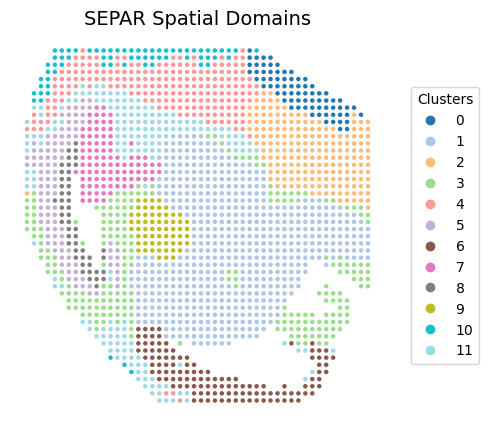

In [8]:
# Perform clustering  
separ.clustering(n_cluster=12, N1=15, N2=1) 

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)  
scatter = ax.scatter(separ.loc[:, 0], -separ.loc[:, 1],   
                    c=separ.labelres, s=5, cmap='tab20')  
plt.title("SEPAR Spatial Domains", fontsize=14)  
plt.axis('off')  

# Add legend  
legend = ax.legend(*scatter.legend_elements(),  
                  title="Clusters",  
                  bbox_to_anchor=(1.05, 0.5),  
                  loc='center left')  

plt.subplots_adjust(right=0.75)  
plt.show()  

## Expression refinemnt

In [9]:
adata_refined = separ.get_refined_expression()

#### Feature Refinement Visualization  

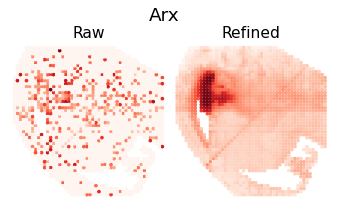

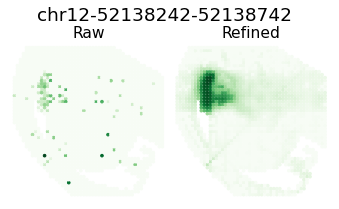

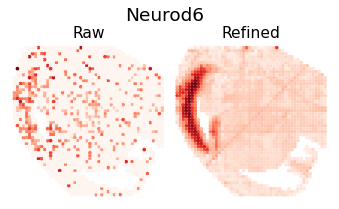

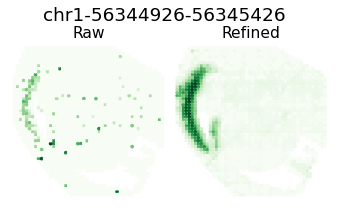

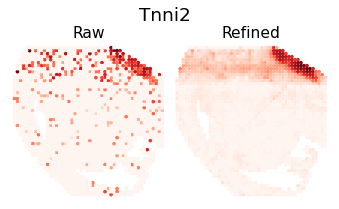

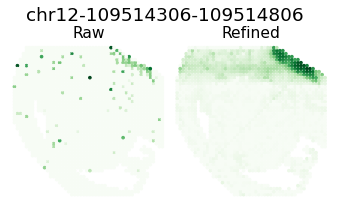

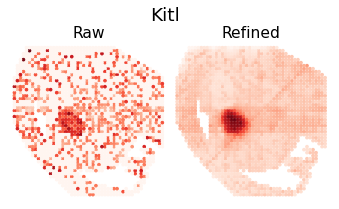

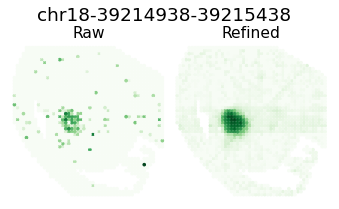

In [14]:
Hp = separ.Hpnn
separ_positions = separ.adata.obsm['spatial']
rna_indices = separ.adata.var['batch'] == 'RNA'  
atac_indices = separ.adata.var['batch'] == 'ATAC'  
for i in [8,16,18,26]:  
    ii = sim_argsort[i]  
    h = Hp[ii, :]  
    rna_max_value = h[rna_indices].max()  
    rna_max_index = np.where(rna_indices)[0][h[rna_indices].argmax()]   
    atac_max_value = h[atac_indices].max()  
    atac_max_index = np.where(atac_indices)[0][h[atac_indices].argmax()] 
    gene_name = separ.adata.var_names[rna_max_index] 
    plt.figure(dpi=70, figsize=(6, 3)) 
    plt.suptitle(f'{gene_name}', fontsize=19, y=1.04)   

    plt.subplot(1, 2, 1)  
    plt.scatter(separ_positions[:, 0], -separ_positions[:, 1],  
                c=separ.adata.X[:, rna_max_index], s=7.3, cmap='Reds')  
    plt.axis('off')  
    plt.title(f'Raw', fontsize=16, pad = -4)  

    plt.subplot(1, 2, 2)  
    plt.scatter(separ_positions[:, 0], -separ_positions[:, 1],  
                c=adata_refined.X[:, rna_max_index], s=7.3, cmap='Reds')  
    plt.axis('off')  
    plt.title(f'Refined', fontsize=16, pad = -4)  

    plt.subplots_adjust(wspace=0, hspace=0)  
    plt.show()

    gene_name = separ.adata.var_names[atac_max_index] 
    plt.figure(dpi=70, figsize=(6, 3)) 
    plt.suptitle(f'{gene_name}', fontsize=19, y=1.04)   

    plt.subplot(1, 2, 1)  
    plt.scatter(separ_positions[:, 0], -separ_positions[:, 1],  
                c=separ.adata.X[:, atac_max_index], s=7.3, cmap='Greens')  
    plt.axis('off')  
    plt.title(f'Raw', fontsize=16, pad = -4)  

    plt.subplot(1, 2, 2)  
    plt.scatter(separ_positions[:, 0], -separ_positions[:, 1],  
                c=adata_refined.X[:, atac_max_index], s=7.3, cmap='Greens')  
    plt.axis('off')  
    plt.title(f'Refined', fontsize=16, pad = -4)  

    plt.subplots_adjust(wspace=0, hspace=0)  
    plt.show()
    